# Прогнозирование с помощью моделей ARIMA и их модификаций

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
data = pd.read_csv('AirPassengers.csv')

In [ ]:
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
data.rename(columns={'#Passengers': 'Passengers'}, inplace=True)

In [ ]:
data

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


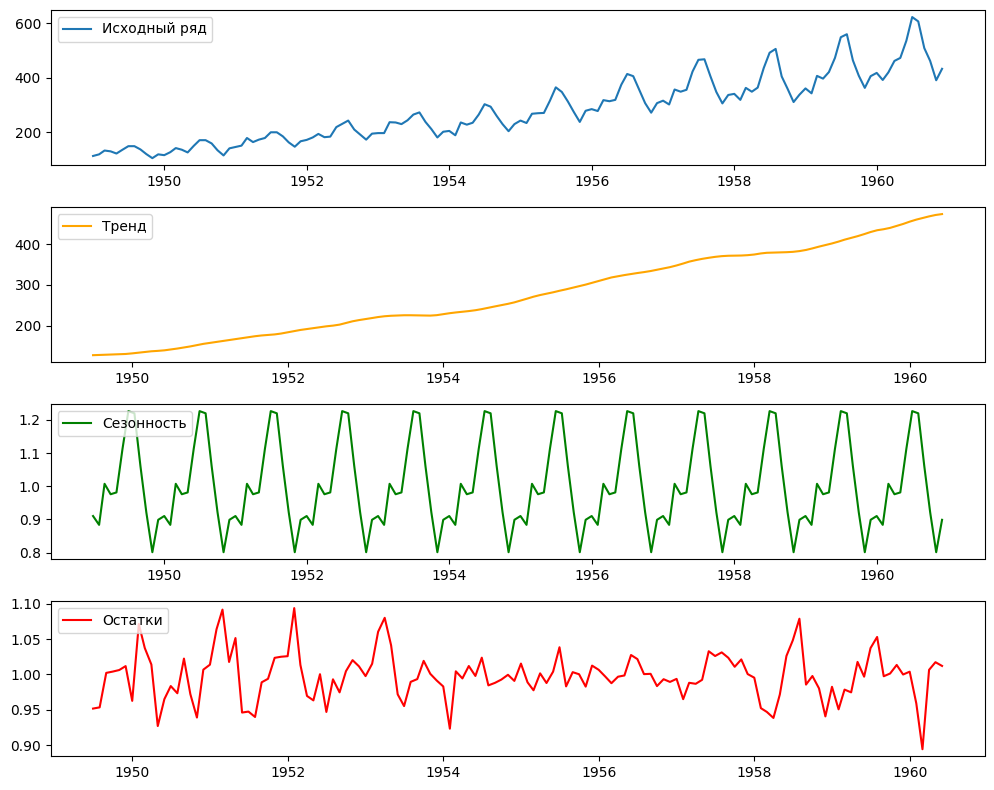

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Разложение временного ряда на компоненты
decomposition = seasonal_decompose(data['Passengers'], model='multiplicative', period=12)
# Построение графиков
plt.figure(figsize=(10, 8))

# Исходный ряд
plt.subplot(4, 1, 1)
plt.plot(data['Passengers'], label='Исходный ряд')
plt.legend(loc='upper left')

# Тренд
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Тренд', color='orange')
plt.legend(loc='upper left')

# Сезонность
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Сезонность', color='green')
plt.legend(loc='upper left')

# Остатки
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Остатки', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

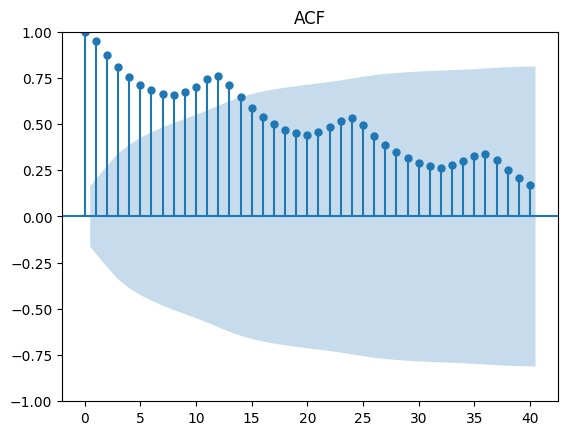

<Figure size 1000x600 with 0 Axes>

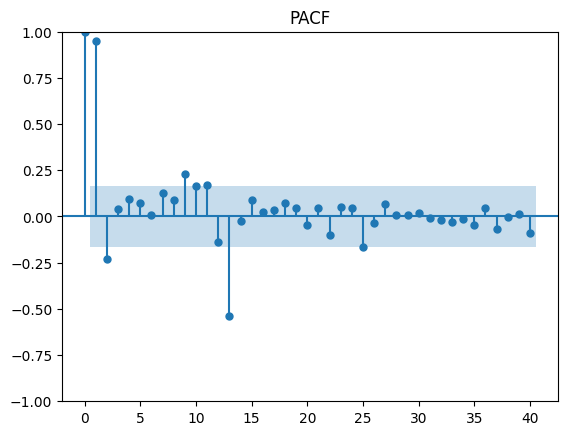

In [ ]:
plt.figure(figsize=(10, 6))
plot_acf(data['Passengers'], lags=40, title='ACF')
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(data['Passengers'], lags=40, title='PACF')
plt.show()


Данные, судя по ACF, являются нестационарными из-за тренда.

По PACF можно предположить наличие AR-компоненты порядка 2 (AR(2)).

In [ ]:
print(data.isnull().sum())

Passengers    0
dtype: int64


In [ ]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Функция для проверки стационарности
def check_stationarity(series, title):
    result = adfuller(series.dropna())
    print(f"\nADF Statistic for {title}: {result[0]}")
    print(f"p-value for {title}: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value}")
    if result[1] <= 0.05:
        print(f"{title} is stationary")
    else:
        print(f"{title} is NOT stationary")

# Проверка стационарности
print("\nOriginal Data Stationarity Test:")
check_stationarity(data['Passengers'], "Original Data")



Original Data Stationarity Test:

ADF Statistic for Original Data: 0.8153688792060498
p-value for Original Data: 0.991880243437641
Critical Values:
  1%: -3.4816817173418295
  5%: -2.8840418343195267
  10%: -2.578770059171598
Original Data is NOT stationary


# SARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Stationarity Test (After SARIMA Transformations):

ADF Statistic for SARIMA Transformations: -20.419486452251903
p-value for SARIMA Transformations: 0.0
Critical Values:
  1%: -3.489057523907491
  5%: -2.887246327182993
  10%: -2.5804808802708528
SARIMA Transformations is stationary

RMSE for SARIMA Model: 25.01


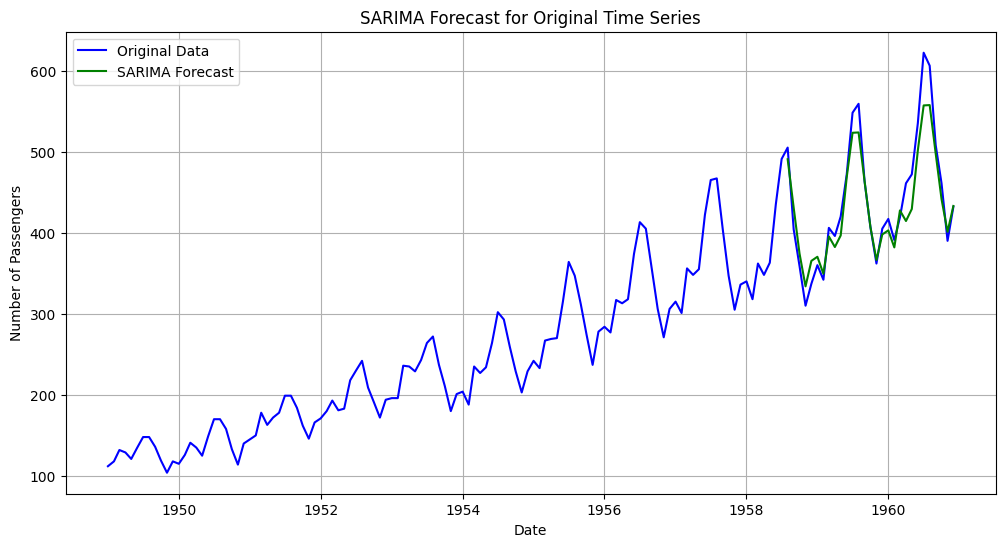

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt

# Разделение данных на обучающую и тестовую выборки
train_size = int(len(data['Passengers']) * 0.8)
train, test = data['Passengers'][:train_size], data['Passengers'][train_size:]

# Построение модели SARIMA
model = SARIMAX(train, order=(2, 2, 1), seasonal_order=(1, 1, 1, 12))  # S=12 для месячной сезонности
model_fit = model.fit(disp=False)

# Извлечение остаточного временного ряда после всех преобразований (дифференцирований)
residuals = model_fit.resid

# Проверка стационарности остаточного ряда (после преобразований SARIMA)
print("\nStationarity Test (After SARIMA Transformations):")
check_stationarity(residuals, "SARIMA Transformations")

# Прогнозирование на тестовой выборке
forecast = model_fit.forecast(steps=len(test))

# Оценка качества модели с помощью RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"\nRMSE for SARIMA Model: {rmse:.2f}")

# Визуализация прогноза и фактических данных
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Passengers'], label="Original Data", color="blue")
plt.plot(test.index, forecast, label="SARIMA Forecast", color="green")
plt.title("SARIMA Forecast for Original Time Series")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid()
plt.show()


# Модель Хольта-Уинтерса

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Holt-Winters Final RMSE: 21.34


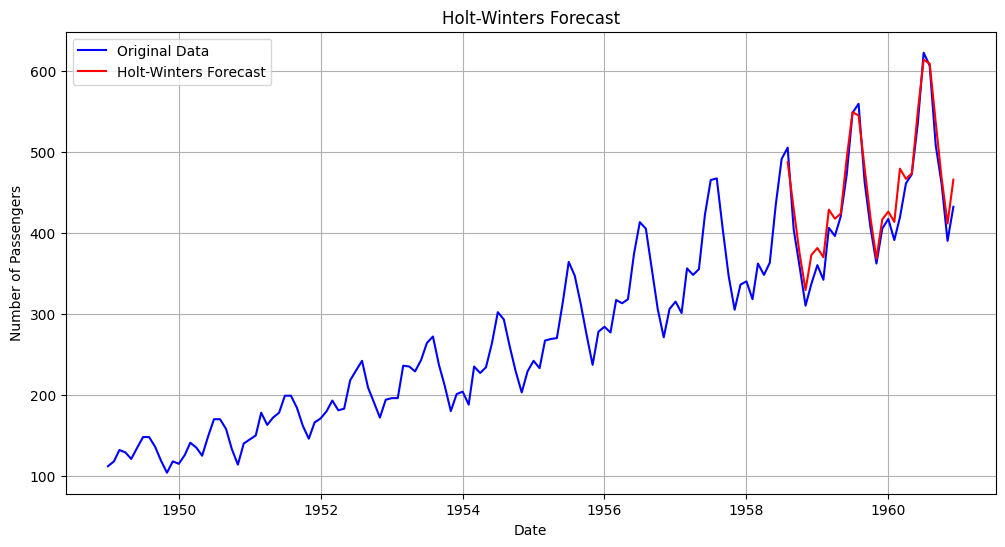

In [ ]:
# Модель Хольта-Уинтерса
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Разделение данных на обучающую и тестовую выборки
train_size = int(len(data['Passengers']) * 0.8)
train, test = data['Passengers'][:train_size], data['Passengers'][train_size:]


from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Модель с мультипликативной сезонностью и линейным трендом
model_hw = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=12)
model_fit_hw = model_hw.fit()


# Прогноз
forecast_hw = model_fit_hw.forecast(steps=len(test))


# Оценка RMSE
rmse_hw = np.sqrt(mean_squared_error(test, forecast_hw))
print(f"Holt-Winters Final RMSE: {rmse_hw:.2f}")

# Визуализация прогноза и фактических данных
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Passengers'], label="Original Data", color="blue")
plt.plot(test.index, forecast_hw, label="Holt-Winters Forecast", color="red")
plt.title("Holt-Winters Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid()
plt.show()


# Тюнинг

In [ ]:
# Установка библиотеки (если не установлена)
! pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.5 MB/s eta 0:00:00



Tuning SARIMA Model:
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

 ARIMA(1,1,0)(1,1,0)[12]             : AIC=755.750, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=756.380, Time=0.18 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,0)[12]             : AIC=755.499, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=755.982, Time=0.19 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[12]             : AIC=757.649, Time=0.31 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=756.771, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,0)[12]             : AIC=756.022, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=756.011, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,0)[12]             : AIC=757.976, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=757.438, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 1.621 seconds

Best SARIMA Model:  ARIMA(1,1,0)(0,1,0)[12]          

SARIMA Final RMSE: 35.08


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



SARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -375.750
Date:                            Fri, 20 Dec 2024   AIC                            755.499
Time:                                    14:50:25   BIC                            760.749
Sample:                                01-01-1949   HQIC                           757.625
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2048      0.090     -2.271      0.023      -0.382      -0.028
sigma2      

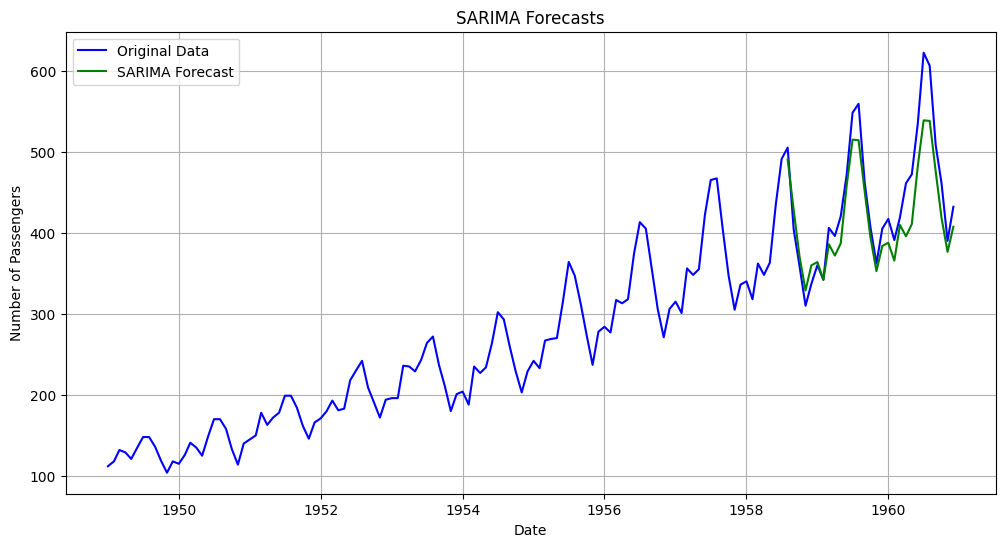

In [ ]:
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt


# SARIMA
train_size = int(len(data['Passengers']) * 0.8)
train_sarima, test_sarima = data['Passengers'][:train_size], data['Passengers'][train_size:]

# Подбор оптимальных параметров SARIMA
print("\nTuning SARIMA Model:")
sarima_model = auto_arima(train_sarima, seasonal=True, m=12, trace=True,
                          error_action='ignore', suppress_warnings=True, stepwise=True,
                          start_p=0, start_q=0, max_p=3, max_q=3,
                          start_P=0, start_Q=0, max_P=2, max_Q=2)

print(f"\nBest SARIMA Model: {sarima_model}")

# Прогноз для SARIMA
sarima_forecast = sarima_model.predict(n_periods=len(test_sarima))

# Оценка RMSE для SARIMA
rmse_sarima = np.sqrt(mean_squared_error(test_sarima, sarima_forecast))
print(f"\nSARIMA Final RMSE: {rmse_sarima:.2f}")

# Вывод таблицы SARIMA
sarima_model_summary = SARIMAX(train_sarima, order=sarima_model.order,
                               seasonal_order=sarima_model.seasonal_order).fit(disp=False)
print("\nSARIMA Model Summary:")
print(sarima_model_summary.summary())

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Passengers'], label="Original Data", color="blue")

# SARIMA Forecast
plt.plot(test_sarima.index, sarima_forecast, label="SARIMA Forecast", color="green")

plt.title("SARIMA Forecasts")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid()
plt.show()
